In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import os, json
import seaborn as sns

def load_and_process_data(benchmark_path: str, results_path: str):
    with open(benchmark_path) as f:
        benchmark = json.load(f)
    with open(results_path) as f:
        results = json.load(f)
        
    df_benchmark = pd.DataFrame.from_dict(benchmark, orient='index')
    
    processed_results = {}
    for pdb_id, data in results.items():
        try:
            processed_results[pdb_id] = {
                'ba_val': data['ba_val'],
                #'kd': data['kd'],
                'CC': data['contacts']['CC'],
                'CP': data['contacts']['CP'],
                'AC': data['contacts']['AC'],
                'PP': data['contacts']['PP'],
                'AP': data['contacts']['AP'],
                'AA': data['contacts']['AA'],
                'nis_p': data['nis']['polar'],
                'nis_a': data['nis']['aliphatic'],
                'nis_c': data['nis']['charged'],
                'execution_time': data['execution_time']["seconds"]
            }
        except KeyError as e:
            print(f"Warning: Missing data for {pdb_id}: {e}")
            continue
            
    df_results = pd.DataFrame.from_dict(processed_results, orient='index')
    
    return df_benchmark, df_results

def calculate_correlations(df_benchmark: pd.DataFrame, df_results: pd.DataFrame):
    common_pdbs = sorted(set(df_benchmark.index) & set(df_results.index))
    print(f"Common PDB entries: {len(common_pdbs)}")
    
    metrics = {
        'ba_val': 'Binding Affinity',
        'CC': 'Charged-Charged contacts',
        'CP': 'Charged-Polar contacts',
        'AC': 'Aliphatic-Charged contacts',
        'PP': 'Polar-Polar contacts',
        'AP': 'Aliphatic-Polar contacts',
        'AA': 'Aliphatic-Aliphatic contacts',
        'nis_p': 'NIS Polar',
        'nis_a': 'NIS Aliphatic',
        'nis_c': 'NIS Charged'
    }
    
    correlations = []
    for metric in metrics:
        if metric in df_benchmark.columns and metric in df_results.columns:
            bench_vals = df_benchmark.loc[common_pdbs, metric]
            result_vals = df_results.loc[common_pdbs, metric]
            pearson = stats.pearsonr(bench_vals, result_vals)
            rmse = np.sqrt(np.mean((bench_vals - result_vals) ** 2))
            correlations.append({
                'Metric': metrics[metric],
                'Pearson r': pearson[0],
                'p-value': pearson[1],
                'RMSE': rmse
            })
    
    return pd.DataFrame(correlations)

def plot_correlations(df_benchmark: pd.DataFrame, df_results: pd.DataFrame, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    common_pdbs = sorted(set(df_benchmark.index) & set(df_results.index))
    
    metrics = {
        'ba_val': 'Binding Affinity',
        'CC': 'Charged-Charged contacts',
        'CP': 'Charged-Polar contacts',
        'AC': 'Aliphatic-Charged contacts',
        'PP': 'Polar-Polar contacts',
        'AP': 'Aliphatic-Polar contacts',
        'AA': 'Aliphatic-Aliphatic contacts',
        'nis_p': 'NIS Polar',
        'nis_a': 'NIS Aliphatic',
        'nis_c': 'NIS Charged'
    }
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (metric, title) in enumerate(metrics.items()):
        if i < len(axes):
            bench_vals = df_benchmark.loc[common_pdbs, metric]
            result_vals = df_results.loc[common_pdbs, metric]
            
            pearson = stats.pearsonr(bench_vals, result_vals)[0]
            
            ax = axes[i]
            ax.scatter(bench_vals, result_vals, alpha=0.6)
            ax.plot([min(bench_vals), max(bench_vals)], 
                   [min(bench_vals), max(bench_vals)], 'r--')
            
            ax.set_xlabel('Prodigy ORG')
            ax.set_ylabel('Prodigy JAX')
            ax.set_title(f'{title}\nr = {pearson:.3f}')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

def add_sequence_lengths(df: pd.DataFrame, pdb_folder: str):
    lengths = {}
    for pdb_id in df.index:
        try:
            pdb_file = os.path.join(pdb_folder, f"{pdb_id}.pdb")
            if os.path.exists(pdb_file):
                with open(pdb_file, 'r') as f:
                    lines = f.readlines()
                    # Count ATOM lines for chain A and B
                    chain_a = sum(1 for line in lines if line.startswith('ATOM') and line[21] == 'A')
                    chain_b = sum(1 for line in lines if line.startswith('ATOM') and line[21] == 'B')
                    # Divide by typical number of atoms per residue (usually around 8-10)
                    lengths[pdb_id] = {
                        'chain_a_length': chain_a // 8,
                        'chain_b_length': chain_b // 8
                    }
        except Exception as e:
            print(f"Error processing {pdb_id}: {e}")
            
    # Add to DataFrame
    length_df = pd.DataFrame.from_dict(lengths, orient='index')
    return pd.concat([df, length_df], axis=1)

def compare_sasa_results(gpu_dir: str, cpu_dir: str):
    gpu_path = Path(gpu_dir)
    cpu_path = Path(cpu_dir)
    all_comparisons = []
    all_sasa_values = []
    
    for protein_dir in gpu_path.glob("*"):
        print("")
        if not protein_dir.is_dir():
            continue
            
        protein_name = protein_dir.name
        gpu_csv = list(protein_dir.rglob("*.csv"))
        cpu_csv = list((cpu_path / protein_name).rglob("*.csv"))
        
        if not gpu_csv or not cpu_csv:
            continue
        
        gpu_data = pd.read_csv(gpu_csv[0])
        gpu_data.resid = gpu_data.resid.astype(int)
        gpu_data = gpu_data.sort_values(['chain', "resname", 'resid', 'atom'])
        cpu_data = pd.read_csv(cpu_csv[0])
        cpu_data.resid = cpu_data.resid.astype(int)
        cpu_data = cpu_data.sort_values(['chain', "resname", 'resid', 'atom'])

        if len(gpu_data) != len(cpu_data):
            print(f"Length mismatch in {protein_name}: GPU={len(gpu_data)}, CPU={len(cpu_data)}")
            continue
        
        comparison = pd.DataFrame({
          'sasa_cpu': cpu_data['sasa'].values,
          'sasa_gpu': gpu_data['sasa'].values,
          'diff': abs(cpu_data['sasa'].values - gpu_data['sasa'].values),
          'protein': protein_name,
          'chain_gpu': gpu_data['chain'].values,
          'resname_gpu': gpu_data['resname'].values, 
          'resid_gpu': gpu_data['resid'].values,
          'atom_gpu': gpu_data['atom'].values,
          'chain_cpu': cpu_data['chain'].values,
          'resname_cpu': cpu_data['resname'].values,
          'resid_cpu': cpu_data['resid'].values, 
          'atom_cpu': cpu_data['atom'].values
        })
        
        all_sasa_values.append(comparison)
        
        rmse = np.sqrt(np.mean(comparison['diff']**2))
        correlation = stats.pearsonr(comparison['sasa_cpu'], comparison['sasa_gpu'])[0]
        
        all_comparisons.append({
            'protein': protein_name,
            'rmse': rmse,
            'correlation': correlation,
            'mean_diff': comparison['diff'].mean(),
            'max_diff': comparison['diff'].max(),
            'num_atoms': len(comparison),
            'num_nonzero': len(comparison[comparison['sasa_gpu'] > 0])
        })
    
    summary_df = pd.DataFrame(all_comparisons)
    all_sasa_df = pd.concat(all_sasa_values)
    
    # Add high_rmse column to all_sasa_df
    high_rmse_proteins = set(summary_df[summary_df['rmse'] > 2]['protein'])
    all_sasa_df['high_rmse'] = all_sasa_df['protein'].isin(high_rmse_proteins)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # RMSE scatter plot
    ax1.scatter(summary_df['num_atoms'], summary_df['rmse'], alpha=0.6)
    for i, txt in enumerate(summary_df['protein']):
        if summary_df['rmse'].iloc[i] > 2:
            ax1.annotate(txt, (summary_df['num_atoms'].iloc[i], summary_df['rmse'].iloc[i]))
    ax1.set_xlabel('Number of Atoms')
    ax1.set_ylabel('RMSE (Å²)')
    ax1.set_title('RMSE GPU and CPU vs Structure Size')
    
    # SASA values comparison with color coding
    normal_points = all_sasa_df[~all_sasa_df['high_rmse']]
    high_rmse_points = all_sasa_df[all_sasa_df['high_rmse']]
    
    ax2.scatter(normal_points['sasa_cpu'], normal_points['sasa_gpu'], alpha=0.1, color='blue')
    
    max_val = max(all_sasa_df['sasa_cpu'].max(), all_sasa_df['sasa_gpu'].max())
    ax2.plot([0, max_val], [0, max_val], 'k--')
    ax2.set_xlabel('CPU SASA (Å²)')
    ax2.set_ylabel('GPU SASA (Å²)')
    ax2.set_title('CPU vs GPU SASA Values')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('sasa_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return summary_df, all_sasa_df

In [ ]:
benchmark = "./benchmark_af/dataset.json"
results = "./benchmark_af/20250126_140901_gpu/combined_results.json"
output = "output_comp"
dataset = "./benchmark_af/PRODIGYdataset/" # make sure you have the dataset
os.makedirs(output, exist_ok=True)
df_benchmark, df_results = load_and_process_data(benchmark, results)
correlations = calculate_correlations(df_benchmark, df_results)
print("\nCorrelation Analysis:")
print(correlations.to_string(index=False))
correlations.to_csv(f'{output}/correlations.csv', index=False)
plot_correlations(df_benchmark, df_results, output)

# Save processed DataFrames
df_benchmark.to_csv(f'{output}/benchmark_processed.csv')
df_results.to_csv(f'{output}/results_processed.csv')

df = add_sequence_lengths(df_results, dataset)
df['total_length'] = df['chain_a_length'] + df['chain_b_length']

plt.figure(figsize=(10, 6))
plt.scatter(df['total_length'], df['execution_time'])

# Add trend line
z = np.polyfit(df['total_length'], df['execution_time'], 1)
p = np.poly1d(z)
plt.plot(df['total_length'], p(df['total_length']), "r--", alpha=0.8)

# Calculate correlation
corr = df['total_length'].corr(df['execution_time'])

plt.xlabel('Total Sequence Length (residues)')
plt.ylabel('Execution Time (s)')
plt.title(f'Execution Time vs Sequence Length\nCorrelation: {corr:.3f}')
plt.grid(True, alpha=0.3)
summary_df, all_sasa_df = compare_sasa_results("./benchmark_af/20250126_140901_gpu", "./benchmark_af/20250127_160612_cpu")


In [ ]:
from bio_lib.custom_prodigy import predict_binding_affinity

predict_binding_affinity("/Users/alessio/Documents/Repos/bio_lib/3bzd.pdb", save_results=True)

In [2]:
import bio_lib.common.protein as Protein
import bio_lib.common.residue_constants as residue_constants
from bio_lib.common.residue_library import default_library as residue_library
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np

# Create constant
SPHERE_POINTS = jnp.array(np.loadtxt("/Users/alessio/Documents/Repos/bio_lib/src/bio_lib/data/thomson100.xyz", skiprows=1))
RESIDUE_RADII_MATRIX = jnp.array(residue_library.radii_matrix)

def load_pdb_to_af(pdb_path: str, target_chain: str, binder_chain: str):
    with open(pdb_path, 'r') as f:
        pdb_str = f.read()
    
    target = Protein.from_pdb_string(pdb_str, chain_id=target_chain)
    binder = Protein.from_pdb_string(pdb_str, chain_id=binder_chain)
    
    return target, binder

def get_atom_radii(aatype: jnp.ndarray) -> jnp.ndarray: ### to docheck this
    seq_one_hot = jax.nn.one_hot(aatype, len(residue_constants.restypes))
    return jnp.matmul(seq_one_hot, RESIDUE_RADII_MATRIX).reshape(-1)

def estimate_sasa_block_size(n_atoms: int, n_sphere_points: int, available_mem: int = 24) -> int:

    # Convert memory to bytes (using 80% of available memory for safety)
    available_mem = available_mem * 1024**3 * 0.8
    bytes_per_float = 4  # float32
    
    # Memory requirements for major arrays in the calculation:
    # 1. block_scaled_points: [block, M, 3] -> block * n_sphere_points * 3
    # 2. scaled_points_norm2: [block, M] -> block * n_sphere_points
    # 3. dot_prod: [block, M, N] -> block * n_sphere_points * n_atoms
    # 4. dist2: [block, M, N] -> block * n_sphere_points * n_atoms
    # 5. is_buried: [block, M, N] -> block * n_sphere_points * n_atoms
    
    # Total memory per block element:
    mem_per_block_element = (
        3 * n_sphere_points +  # block_scaled_points
        n_sphere_points +      # scaled_points_norm2
        n_sphere_points * n_atoms +  # dot_prod
        n_sphere_points * n_atoms +  # dist2
        n_sphere_points * n_atoms    # is_buried
    ) * bytes_per_float * 12
    
    # Calculate maximum block size
    block_size = int(available_mem / mem_per_block_element)
    
    # Ensure block size is at least 1 and no larger than n_atoms
    block_size = max(1, min(block_size, n_atoms))
    
    return block_size

def calculate_sasa2(
    coords: jnp.ndarray, 
    vdw_radii: jnp.ndarray, 
    mask: jnp.ndarray, 
    block_size: jnp.ndarray,
    sphere_points: jnp.ndarray = SPHERE_POINTS,
    probe_radius: float = 1.4,
) -> jnp.ndarray:
    """
    Calculate the solvent-accessible surface area (SASA).
    """
    # Apply mask to coordinates and radii
    masked_coords = coords * mask[:, None]  # [N, 3]
    masked_radii = vdw_radii * mask        # [N]
    radii_with_probe = (masked_radii + probe_radius) * mask  # [N]

    # Interaction matrix: check for overlapping atoms
    diff = masked_coords[:, None, :] - masked_coords[None, :, :]  # [N, N, 3]
    dist2 = jnp.sum(diff ** 2, axis=-1)  # [N, N]
    radsum2 = (radii_with_probe[:, None] + radii_with_probe[None, :]) ** 2
    interaction_matrix = (dist2 <= radsum2) & ~jnp.eye(coords.shape[0], dtype=bool)

    n_atoms = coords.shape[0]
    n_points = sphere_points.shape[0]
    buried_points = jnp.zeros((n_atoms, n_points), dtype=bool)

    # Process atoms in blocks to reduce peak memory usage
    for start_idx in range(0, n_atoms, block_size):
        end_idx = min(start_idx + block_size, n_atoms)
        
        # Calculate scaled points for this block
        block_scaled_points = (sphere_points[None, :, :] * 
                             radii_with_probe[start_idx:end_idx, None, None] + 
                             masked_coords[start_idx:end_idx, None, :])  # [block, M, 3]
        
        # Calculate distances to all atoms using a more memory-efficient formulation
        # |a-b|² = |a|² + |b|² - 2⟨a,b⟩
        scaled_points_norm2 = jnp.sum(block_scaled_points**2, axis=-1)  # [block, M]
        coords_norm2 = jnp.sum(masked_coords**2, axis=-1)  # [N]
        
        # Compute dot product term efficiently
        dot_prod = jnp.einsum('bms,ns->bmn', 
                            block_scaled_points,  # [block, M, 3]
                            masked_coords)        # [N, 3]
        
        # Calculate distances
        dist2 = (scaled_points_norm2[:, :, None] + 
                coords_norm2[None, None, :] - 
                2 * dot_prod)  # [block, M, N]
        
        # Check which points are buried
        is_buried = (dist2 <= radii_with_probe[None, None, :]**2) & \
                   interaction_matrix[start_idx:end_idx, None, :]
        block_buried = jnp.any(is_buried, axis=-1)  # [block, M]
        
        # Update buried points for this block
        buried_points = buried_points.at[start_idx:end_idx].set(block_buried)

    # Calculate final SASA
    n_accessible = n_points - jnp.sum(buried_points, axis=-1)
    areas = 4.0 * jnp.pi * (radii_with_probe ** 2)
    sasa = areas * (n_accessible / n_points)

    return sasa

W0000 00:00:1738084733.906141 4001943 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1738084733.918088 4001943 service.cc:145] XLA service 0x12857b8d0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738084733.918098 4001943 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1738084733.919528 4001943 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1738084733.919549 4001943 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [21]:
pdb_path = "/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/1ACB.pdb" #1ACB
target_chain, binder_chain = "A", "B"

target, binder = load_pdb_to_af(pdb_path, target_chain, binder_chain)
complex_positions = jnp.concatenate([target.atom_positions, binder.atom_positions], axis=0).reshape(-1, 3)
complex_radii = jnp.concatenate([get_atom_radii(target.aatype), get_atom_radii(binder.aatype)])
complex_mask = jnp.concatenate([target.atom_mask, binder.atom_mask], axis=0).reshape(-1)

print("Convert sequences to one-hot")
num_classes = len(residue_constants.restypes)
target_seq = jax.nn.one_hot(target.aatype, num_classes=num_classes) #sequence_to_onehot
binder_seq = jax.nn.one_hot(binder.aatype, num_classes=num_classes)
total_seq = jnp.concatenate([target_seq, binder_seq])
bs = estimate_sasa_block_size(n_atoms=len(complex_positions), n_sphere_points=SPHERE_POINTS.shape[0], available_mem=24)
complex_sasa = calculate_sasa2(coords=complex_positions, vdw_radii=complex_radii, mask=complex_mask, block_size=bs)


Convert sequences to one-hot


127

(11248, 3)
Block size 5:
  Run times: ['13.29s', '12.62s', '12.30s']
  Mean: 12.74s, Median: 12.62s, Std: 0.42s
Block size 28:
  Run times: ['5.02s', '4.66s', '4.02s']
  Mean: 4.57s, Median: 4.66s, Std: 0.41s
Block size 52:
  Run times: ['3.67s', '3.04s', '3.04s']
  Mean: 3.25s, Median: 3.04s, Std: 0.30s
Block size 76:
  Run times: ['3.32s', '2.87s', '2.85s']
  Mean: 3.01s, Median: 2.87s, Std: 0.22s
Block size 100:
  Run times: ['3.53s', '2.77s', '2.83s']
  Mean: 3.04s, Median: 2.83s, Std: 0.35s


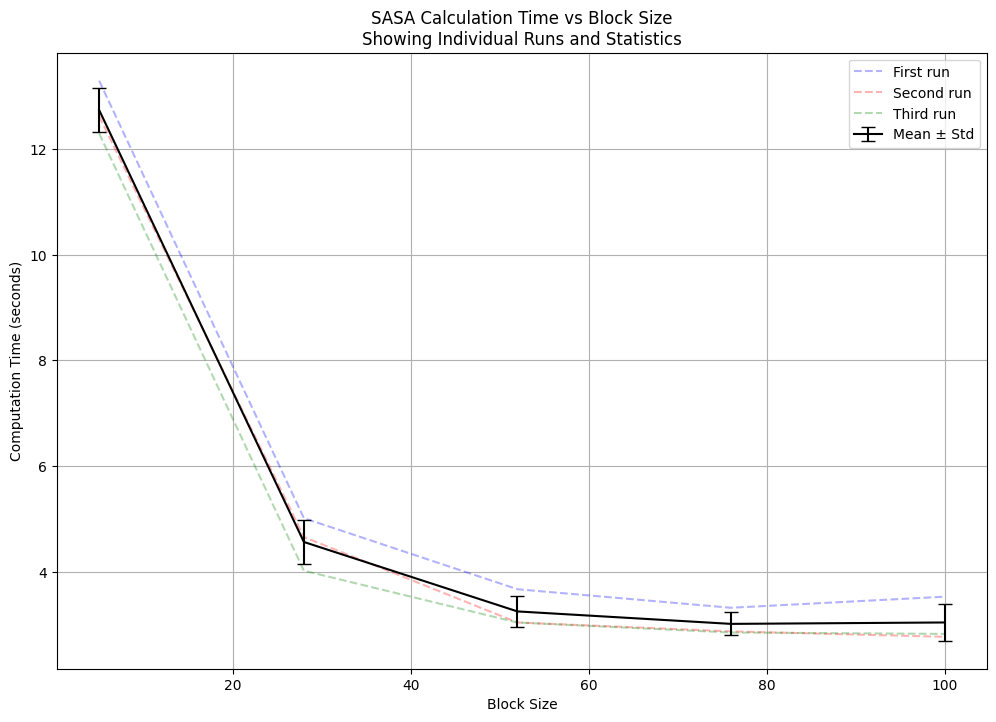


Average times across all block sizes:
First runs:  5.77s
Second runs: 5.19s
Third runs:  5.01s

Compilation overhead: 13.2%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as jnp

pdb_path = "/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/1ACB.pdb" #1ACB 1GCQ 100 and 300 
target_chain, binder_chain = "A", "B"

target, binder = load_pdb_to_af(pdb_path, target_chain, binder_chain)
complex_positions = jnp.concatenate([target.atom_positions, binder.atom_positions], axis=0).reshape(-1, 3)
complex_radii = jnp.concatenate([get_atom_radii(target.aatype), get_atom_radii(binder.aatype)])
complex_mask = jnp.concatenate([target.atom_mask, binder.atom_mask], axis=0).reshape(-1)

num_classes = len(residue_constants.restypes)
target_seq = jax.nn.one_hot(target.aatype, num_classes=num_classes) #sequence_to_onehot
binder_seq = jax.nn.one_hot(binder.aatype, num_classes=num_classes)
total_seq = jnp.concatenate([target_seq, binder_seq])
print(complex_positions.shape)

block_sizes = np.linspace(5, 100, 5, dtype=int)  # Using your block sizes
times_per_run = {1: [], 2: [], 3: []}
statistics = []

# Benchmark each block size
for bs in block_sizes:
    jax.clear_caches()
    run_times = []
    
    for run in range(3):
        start_time = time.time()
        complex_sasa = calculate_sasa2(
            coords=complex_positions, 
            vdw_radii=complex_radii, 
            mask=complex_mask, 
            block_size=bs
        )
        elapsed_time = time.time() - start_time
        run_times.append(elapsed_time)
        times_per_run[run+1].append(elapsed_time)
    
    # Calculate statistics
    mean_time = np.mean(run_times)
    median_time = np.median(run_times)
    std_time = np.std(run_times)
    statistics.append({
        'block_size': bs,
        'mean': mean_time,
        'median': median_time,
        'std': std_time,
        'runs': run_times
    })
    print(f"Block size {bs}:")
    print(f"  Run times: {[f'{t:.2f}s' for t in run_times]}")
    print(f"  Mean: {mean_time:.2f}s, Median: {median_time:.2f}s, Std: {std_time:.2f}s")

# Create plot
plt.figure(figsize=(12, 8))

# Plot individual runs
plt.plot(block_sizes, times_per_run[1], 'b--', alpha=0.3, label='First run')
plt.plot(block_sizes, times_per_run[2], 'r--', alpha=0.3, label='Second run')
plt.plot(block_sizes, times_per_run[3], 'g--', alpha=0.3, label='Third run')

# Plot mean with error bars
means = [stat['mean'] for stat in statistics]
stds = [stat['std'] for stat in statistics]
plt.errorbar(block_sizes, means, yerr=stds, fmt='k-', label='Mean ± Std', capsize=5)

plt.xlabel('Block Size')
plt.ylabel('Computation Time (seconds)')
plt.title('SASA Calculation Time vs Block Size\nShowing Individual Runs and Statistics')
plt.grid(True)
plt.legend()
plt.show()

# Print analysis of compilation effect
first_runs = np.mean(times_per_run[1])
second_runs = np.mean(times_per_run[2])
third_runs = np.mean(times_per_run[3])

print("\nAverage times across all block sizes:")
print(f"First runs:  {first_runs:.2f}s")
print(f"Second runs: {second_runs:.2f}s")
print(f"Third runs:  {third_runs:.2f}s")
print(f"\nCompilation overhead: {((first_runs - third_runs) / first_runs * 100):.1f}%")

In [5]:
print(len(total_seq))

304


Skipping /Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/2VIR.pdb - too many atoms (25826)
Skipping /Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/1DE4.pdb - too many atoms (60717)

Processing /Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/1CBW.pdb
Number of atoms: 10989
Estimated optimal block size: 79
Testing block sizes: [59 63 67 71 75 79]
Block size 59:
  Run times: ['3.63s']
  Mean: 3.63s, Median: 3.63s, Std: 0.00s
Block size 63:
  Run times: ['3.36s']
  Mean: 3.36s, Median: 3.36s, Std: 0.00s
Block size 67:
  Run times: ['3.43s']
  Mean: 3.43s, Median: 3.43s, Std: 0.00s
Block size 71:
  Run times: ['3.37s']
  Mean: 3.37s, Median: 3.37s, Std: 0.00s
Block size 75:
  Run times: ['3.35s']
  Mean: 3.35s, Median: 3.35s, Std: 0.00s
Block size 79:
  Run times: ['3.32s']
  Mean: 3.32s, Median: 3.32s, Std: 0.00s


KeyError: 2

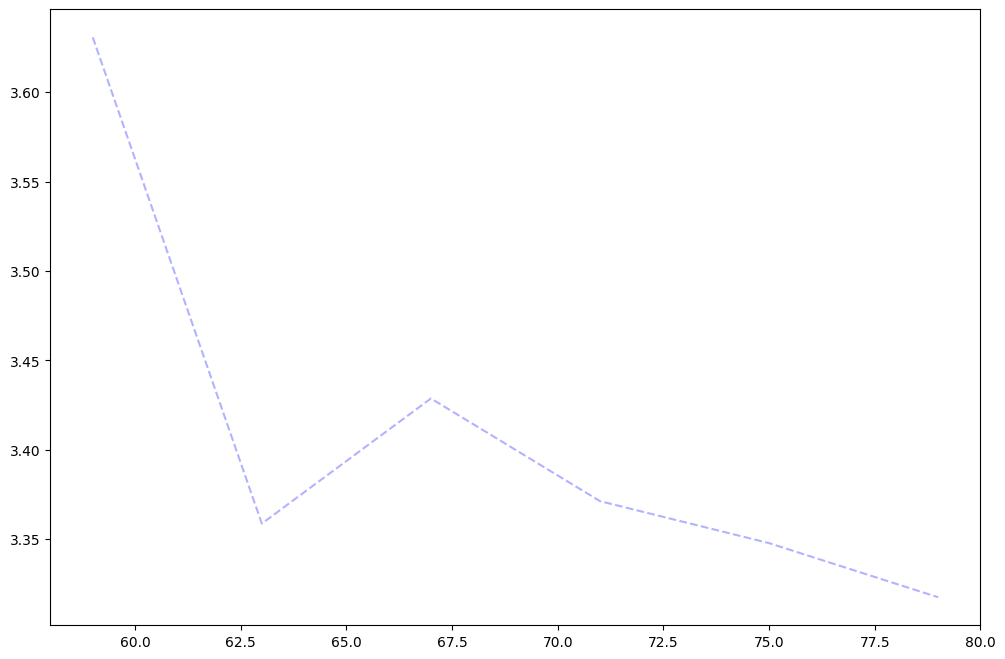

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as jnp
import os
from scipy import stats

def estimate_optimal_block_size(n_atoms: int) -> int:
    # Known optimal points (n_atoms, block_size)
    known_points = [
        (4500, 250),
        (11200, 80),
        (25826, 25)  # New data point
    ]
    
    # Convert to log space for linear regression
    log_atoms = np.log([p[0] for p in known_points])
    log_blocks = np.log([p[1] for p in known_points])
    
    # Perform linear regression in log space
    slope, intercept, _, _, _ = stats.linregress(log_atoms, log_blocks)
    
    # Estimate block size using the regression model
    log_estimate = slope * np.log(n_atoms) + intercept
    block_size = int(round(np.exp(log_estimate)))
    
    # Add tighter bounds to prevent memory issues
    max_block = min(
        250,  # absolute maximum
        int(5000 / np.sqrt(n_atoms/1000))  # dynamic limit based on atom count
    )
    
    return max(5, min(block_size, max_block))

def benchmark_sasa_for_pdb(pdb_path):
   """Run SASA benchmark for a single PDB file"""
   
   # Load and prepare PDB data
   target, binder = load_pdb_to_af(pdb_path, "A", "B")
   complex_positions = jnp.concatenate([target.atom_positions, binder.atom_positions], axis=0).reshape(-1, 3)
   complex_radii = jnp.concatenate([get_atom_radii(target.aatype), get_atom_radii(binder.aatype)])
   complex_mask = jnp.concatenate([target.atom_mask, binder.atom_mask], axis=0).reshape(-1)
   
   n_atoms = complex_positions.shape[0]
   
   # Skip if too many atoms (e.g. > 15000)
   if n_atoms > 20000:
       print(f"Skipping {pdb_path} - too many atoms ({n_atoms})")
       return None
       
   # Estimate optimal block size and create range around it
   optimal_bs = estimate_optimal_block_size(n_atoms)
   min_bs = max(5, optimal_bs - 20)
   max_bs = min(optimal_bs, optimal_bs + 10) 
   block_sizes = np.linspace(min_bs, max_bs, 8, dtype=int)
   
   times_per_run = {1: [], 2: [], 3: []}
   #times_per_run = {1: []}

   statistics = []
   
   print(f"\nProcessing {pdb_path}")
   print(f"Number of atoms: {n_atoms}")
   print(f"Estimated optimal block size: {optimal_bs}")
   print(f"Testing block sizes: {block_sizes}")
   
   # Benchmark each block size
   for bs in block_sizes:
       jax.clear_caches()
       run_times = []
       
       for run in range(3):
           start_time = time.time()
           complex_sasa = calculate_sasa2(
               coords=complex_positions,
               vdw_radii=complex_radii,
               mask=complex_mask,
               block_size=bs
           )
           elapsed_time = time.time() - start_time
           run_times.append(elapsed_time)
           times_per_run[run+1].append(elapsed_time)
           
       mean_time = np.mean(run_times)
       median_time = np.median(run_times)
       std_time = np.std(run_times)
       
       statistics.append({
           'block_size': bs,
           'mean': mean_time,
           'median': median_time,
           'std': std_time,
           'runs': run_times
       })
       print(f"Block size {bs}:")
       print(f"  Run times: {[f'{t:.2f}s' for t in run_times]}")
       print(f"  Mean: {mean_time:.2f}s, Median: {median_time:.2f}s, Std: {std_time:.2f}s")
   
   # Create plot
   plt.figure(figsize=(12, 8))
   
   plt.plot(block_sizes, times_per_run[1], 'b--', alpha=0.3, label='First run')
   plt.plot(block_sizes, times_per_run[2], 'r--', alpha=0.3, label='Second run')
   plt.plot(block_sizes, times_per_run[3], 'g--', alpha=0.3, label='Third run')
   
   means = [stat['mean'] for stat in statistics]
   stds = [stat['std'] for stat in statistics]
   plt.errorbar(block_sizes, means, yerr=stds, fmt='k-', label='Mean ± Std', capsize=5)
   
   plt.xlabel('Block Size')
   plt.ylabel('Computation Time (seconds)')
   plt.title(f'SASA Calculation Time vs Block Size for {os.path.basename(pdb_path)}\n{n_atoms} atoms')
   plt.grid(True)
   plt.legend()
   plt.show()
   
   # Print statistics
   first_runs = np.mean(times_per_run[1])
   second_runs = np.mean(times_per_run[2])
   third_runs = np.mean(times_per_run[3])
   
   print("\nAverage times across all block sizes:")
   print(f"First runs:  {first_runs:.2f}s")
   print(f"Second runs: {second_runs:.2f}s")
   print(f"Third runs:  {third_runs:.2f}s")
   print(f"Compilation overhead: {((first_runs - third_runs) / first_runs * 100):.1f}%")
   
   # Return best block size
   best_idx = np.argmin(means)
   return block_sizes[best_idx]

def process_prodigy_dataset(dataset_path):
   """Process all PDB files in the PRODIGY dataset"""
   results = {}
   
   for pdb_file in os.listdir(dataset_path):
       if pdb_file.endswith('.pdb'):
           pdb_path = os.path.join(dataset_path, pdb_file)
           
           # Assuming all files use chains A and B
           best_bs = benchmark_sasa_for_pdb(pdb_path)
           
           if best_bs is not None:
               results[pdb_file] = best_bs
               
   return results

# Run the benchmarks
dataset_path = "/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/"
results = process_prodigy_dataset(dataset_path)

# Print summary of results
print("\nOptimal block sizes for each PDB:")
for pdb, block_size in results.items():
   print(f"{pdb}: {block_size}")